In [1]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
from google.colab import drive
drive.mount('/content/drive')
# store data here for notebook access

Mounted at /content/drive


In [2]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
from torch.utils.data import Dataset
# dataset class in pytorch which is the data that will get fed into the NN

In [3]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# === MODEL INITIALIZATION ===
# Define or load the binary segmentation model configuration
# install and Clone Github segmentation models pytorch
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [6]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import os
import shutil
import random

# Set up source and target directories
SOURCE_DIR = '/content/drive/My Drive/Colab Notebooks/images_energ_binary/'
source_images = os.path.join(SOURCE_DIR, 'source_images')
source_masks = os.path.join(SOURCE_DIR, 'source_masks')

DATA_DIR = '/content/drive/My Drive/Colab Notebooks/images_energ_binary/'

x_train_dir = os.path.join(DATA_DIR, 'XTrain')
y_train_dir = os.path.join(DATA_DIR, 'yTrain')

x_valid_dir = os.path.join(DATA_DIR, 'XVal')
y_valid_dir = os.path.join(DATA_DIR, 'yVal')

x_test_dir = os.path.join(DATA_DIR, 'XTest')
y_test_dir = os.path.join(DATA_DIR, 'yTest')

#########################################################################################
# Use when splitting data into Tr/Te/Va
# # Get list of all files
# all_images = os.listdir(source_images)
# all_masks = os.listdir(source_masks)

# # Create a dictionary of masks, keyed by their unique identifiers
# mask_dict = {file[2:]: file for file in all_masks}

# # Pair each image with its corresponding mask, using the unique part of the filename
# paired_files = []
# for img_file in all_images:
#     unique_identifier = img_file[2:]  # Remove 's-' prefix
#     if unique_identifier in mask_dict:
#         paired_files.append((img_file, mask_dict[unique_identifier]))
#     else:
#         print(f"No corresponding mask found for image {img_file}")

# random.shuffle(paired_files)

# # Calculate split sizes
# train_size = int(0.7 * len(paired_files))
# valid_size = int(0.2 * len(paired_files))
# test_size = len(paired_files) - train_size - valid_size

# # Split files
# train_files = paired_files[:train_size]
# valid_files = paired_files[train_size:train_size+valid_size]
# test_files = paired_files[train_size+valid_size:]

# # Function to move files
# def move_files(file_list, src_images, src_masks, dest_images, dest_masks):
#     for img_file, mask_file in file_list:
#         shutil.move(os.path.join(src_images, img_file), os.path.join(dest_images, img_file))
#         shutil.move(os.path.join(src_masks, mask_file), os.path.join(dest_masks, mask_file))

# # Move files to their respective directories
# move_files(train_files, source_images, source_masks, x_train_dir, y_train_dir)
# move_files(valid_files, source_images, source_masks, x_valid_dir, y_valid_dir)
# move_files(test_files, source_images, source_masks, x_test_dir, y_test_dir)

In [12]:
# print(f"Train size: {train_size}")
# print(f"Validation size: {valid_size}")
# print(f"Test size: {test_size}")

In [14]:
# print("Sample train files:", train_files[:5])
# print("Sample validation files:", valid_files[:5])
# print("Sample test files:", test_files[:5])

In [7]:
path, dirs, files = next(os.walk(y_train_dir))
file_count = len(files)
print(file_count)

# use this to see how many files in each folder

2962


In [ ]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
# import PIL
# import os
# import os.path
# from PIL import Image

# f = x_test_dir
# for file in os.listdir(f):
#     f_img = f+"/"+file
#     img = Image.open(f_img)
#     img = img.resize((544,960))
#     img.save(f_img)

In [ ]:
# g = y_test_dir
# for file in os.listdir(g):
#     f_img = g+"/"+file
#     img = Image.open(f_img)
#     img = img.resize((544,960))
#     img.save(f_img)

In [8]:
# CLASSES = ['instrument', 'background']
CLASSES = ['instrument']

In [9]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
from torch.utils.data import Dataset as BaseDataset

In [10]:
# === DATASET AND DATALOADER ===
# Prepare dataset class and dataloaders for training and validation
class Dataset(BaseDataset):
    """TrayDataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        # get images(x) and masks(y) ids
        self.ids_x = sorted(os.listdir(images_dir))
        #['1001a01.jpg', '1005a.jpg', '1006a72.jpg', '2001a72.jpg', '2002a.jpg'] etc.
        self.ids_y = sorted(os.listdir(masks_dir))

        # get images(x) and masks(y) full paths (fps)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        #'/content/drive/My Drive/Colab Notebooks/TrayDataset/XTest/1001a01.jpg'
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_y]

        # convert str names to class values on masks
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (544,960)) #######
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # get filenames #### added 11/2
        image_name = self.ids_x[i]
        mask_name = self.ids_y[i]

        return image, mask#, image_name, mask_name
        # image_name and mask_name during training, modify your training loop to accept these additional values. For example: for data in train_loader:
        # x, y, x_name, y_name = data
        # Now use x and y for training


    def __len__(self):
        return len(self.ids_x)

In [11]:
# === VISUALIZATION ===
# Display images, masks, and predictions for inspection
def visualize(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Mask'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")

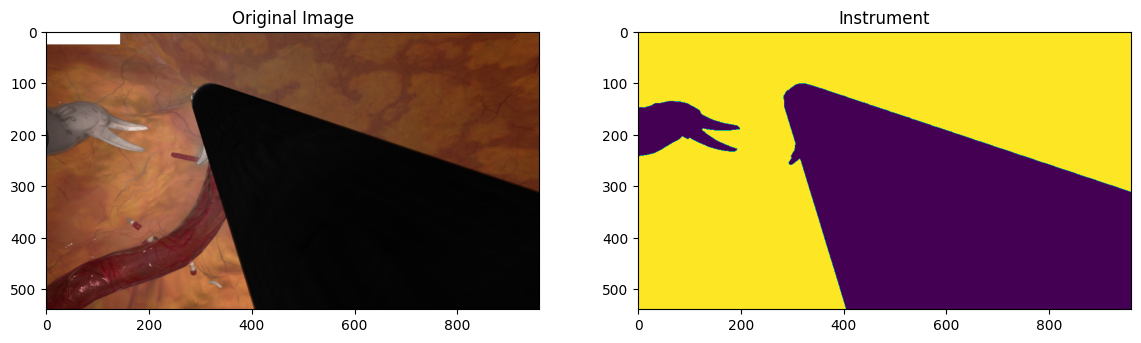

In [12]:
# === DATASET AND DATALOADER ===
# Prepare dataset class and dataloaders for training and validation
for label  in CLASSES:
    dataset = Dataset(x_test_dir, y_test_dir, classes=[label])
    image, mask = dataset[4]
    visualize(
        image=image, mask=mask.squeeze(),
        label  = label )

# for label in CLASSES:
#     dataset = Dataset(x_test_dir, y_test_dir, classes=[label])
#     image, mask, image_name, mask_name = dataset[4]
#     visualize(
#         image=image, mask=mask.squeeze(),
#         label=label
#     )

In [13]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import albumentations as albu
# https://albumentations.ai/docs/api_reference/augmentations/geometric/resize/

In [14]:
# === VISUALIZATION ===
# Display images, masks, and predictions for inspection
def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=544, min_width=960, border_mode=cv2.BORDER_CONSTANT, value=0, p=1),
        # albu.Resize(540, 960, p=1), #256, 416 ####### ### NOTE: RESIZE IN DIFF WAYS, GET DIFF RESULTS # 544, 960,
# 544: This is the desired height of the resized image, in pixels.
# 960: This is the desired width of the resized image, in pixels.
# p=1: This is an optional argument that specifies the probability of applying the resizing operation. In this case, it is set to 1, which means the resizing will be applied with 100% probability.
        albu.HorizontalFlip(p=0.5),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        albu.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(544, 960, border_mode=cv2.BORDER_CONSTANT, value=0, p=1) #544 960 #256, 416 ####### #################################CAREFUL 11/14 540 IS NOT DIVISIBLE BY 32 # 512 does not work
    ]
    return albu.Compose(test_transform)
    # border_mode=cv2.BORDER_CONSTANT: Specifies the padding method. Here, I used a constant value (usually black).
    # value=0: The padding pixels will be black (0 in all channels for RGB images).
    # p=1: The probability that this augmentation will be applied, set to 1 to always apply it.
    # If resizing is not desirable (as it might distort the image), you can pad your images to the nearest dimensions that are divisible by 32. For instance, you can pad the height to 544 pixels.
    # The padding will add extra rows or columns of pixels (usually filled with zeros or replicated edge values) to reach the required size.
# 544: This is the desired minimum height of the padded image, in pixels.
# 960: This is the desired minimum width of the padded image, in pixels.
# The purpose of this function is to pad an image with zeros (or a specified value) so that it meets the desired minimum height and width. If the image is already larger than the specified minimum dimensions, then no padding will be applied.

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [15]:
# === VISUALIZATION ===
# Display images, masks, and predictions for inspection
# helper function for data visualization
def visualizeData(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [16]:
# === DATASET AND DATALOADER ===
# Prepare dataset class and dataloaders for training and validation
augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['instrument'],
)

# same image with different transforms
# for i in range(5):
#     # image, mask = augmented_dataset[8]
#     image, mask, image_name, mask_name = augmented_dataset[8]
#     visualizeData(image=image, mask=mask.squeeze(-1))

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


In [17]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import re
import torch.nn as nn


class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass


class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)


class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)
class Activation(nn.Module):

    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)

In [18]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import torch


def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union


jaccard = iou


def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score


def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score


def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

In [19]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import torch.nn as nn

class JaccardLoss(Loss):
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - jaccard(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class DiceLoss(Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class L1Loss(nn.L1Loss, Loss):
    pass


class MSELoss(nn.MSELoss, Loss):
    pass


class CrossEntropyLoss(nn.CrossEntropyLoss, Loss):
    pass


class NLLLoss(nn.NLLLoss, Loss):
    pass


class BCELoss(nn.BCELoss, Loss):
    pass


class BCEWithLogitsLoss(nn.BCEWithLogitsLoss, Loss):
    pass

    # https://www.scitepress.org/Papers/2021/103040/103040.pdf

In [20]:
class IoU(Metric):
    __name__ = "iou_score"

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return iou(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Fscore(Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return f_score(
            y_pr,
            y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Accuracy(Metric):
    def __init__(self, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return accuracy(
            y_pr,
            y_gt,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Recall(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return recall(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Precision(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return precision(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [21]:
metrics = [
    IoU(threshold=0.5),
    Accuracy(threshold=0.5),
    Fscore(threshold=0.5),
    Recall(threshold=0.5),
    Precision(threshold=0.5),
]

In [22]:
# === MODEL INITIALIZATION ===
# Define or load the binary segmentation model configuration
# install and Clone Github segmentation models pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xnx1vqkc
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xnx1vqkc
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=

In [23]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import torch
import segmentation_models_pytorch as smp

In [24]:
# resnext50_32x4d, mit_b2, timm-gernet_s, efficientnet-b3, mobilenet_v2, resnet152, vgg13		# EXPERIMENT HERE WITH TRUE DATA
ENCODER = 'efficientnet-b3' # extracts feature map and increases channels
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
# decoders= PAN, PSPNet, MAnet, Linknet, FPN, DeepLabV3, DeepLabV3Plus, Unet  # upsamples feature maps and decreases channels and outputs segmentation maps    # EXPERIMENT HERE WITH TRUE DATA
model =smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
# normalize your data the same way as during encoder weight pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


# smp is the library for encoders and decoders
# resnet encoder commonly used in image segmentation
# pspnet architecture: can use any encoder, used for semantic segmentation, cnn/pyramid pooling
# pan architecture (pyramid attention network): good for semantic segmentation
# unet arhcitecture: semantic segmentation for biomedical images
# do: resnet50/unet or ++, efficientnet-b3/fpn, mobilenet_v2/pspnet

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 205MB/s]


In [93]:
print(model)

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [25]:
# === MODEL INITIALIZATION ===
# Define or load the binary segmentation model configuration
# define optimization algorithm with learning rate # EXPERIMENT WITH RMSPROP AND ADAM
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001), #0.0001 # EXPERIMENT HERE WITH TRUE DATA
])

# define loss function
loss = BCEWithLogitsLoss() #DiceLoss() # EXPERIMENT HERE WITH BOTH LOSSES

In [26]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
from torch.utils.data import DataLoader

In [27]:
# === DATASET AND DATALOADER ===
# Prepare dataset class and dataloaders for training and validation
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


In [28]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import numpy as np


class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # this is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [29]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import sys
import torch
from tqdm import tqdm as tqdm

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

    # # for unpacking two items only: mask, image
    # def run(self, dataloader):
    # self.on_epoch_start()

    # logs = {}
    # loss_meter = AverageValueMeter()
    # metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

    # with tqdm(
    #     dataloader,
    #     desc=self.stage_name,
    #     file=sys.stdout,
    #     disable=not (self.verbose),
    # ) as iterator:
    #     for x, y in iterator:  # Updated to handle two items
    #         x, y = x.to(self.device), y.to(self.device)
    #         loss, y_pred = self.batch_update(x, y)

    #         # update loss logs
    #         loss_value = loss.cpu().detach().numpy()
    #         loss_meter.add(loss_value)
    #         loss_logs = {self.loss.__name__: loss_meter.mean}
    #         logs.update(loss_logs)

    #         # update metrics logs
    #         for metric_fn in self.metrics:
    #             metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
    #             metrics_meters[metric_fn.__name__].add(metric_value)
    #         metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
    #         logs.update(metrics_logs)

    #         if self.verbose:
    #             s = self._format_logs(logs)
    #             iterator.set_postfix_str(s)

    # return logs

    # # other run method to handle image_names and mask_names 
    # def run(self, dataloader):
    #     self.on_epoch_start()

    #     logs = {}
    #     loss_meter = AverageValueMeter()
    #     metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

    #     with tqdm(
    #         dataloader,
    #         desc=self.stage_name,
    #         file=sys.stdout,
    #         disable=not (self.verbose),
    #     ) as iterator:
    #         for data in iterator:  # Changed line
    #             x, y, image_names, mask_names = data  # Changed line # for x, y in dataloader:  # Change this line
    #             x, y = x.to(self.device), y.to(self.device)
    #             loss, y_pred = self.batch_update(x, y)

    #             # update loss logs
    #             loss_value = loss.cpu().detach().numpy()
    #             loss_meter.add(loss_value)
    #             loss_logs = {self.loss.__name__: loss_meter.mean}
    #             logs.update(loss_logs)

    #             # update metrics logs
    #             for metric_fn in self.metrics:
    #                 metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
    #                 metrics_meters[metric_fn.__name__].add(metric_value)
    #             metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
    #             logs.update(metrics_logs)

    #             if self.verbose:
    #                 s = self._format_logs(logs)
    #                 iterator.set_postfix_str(s)

    #     return logs


# class ValidEpoch(Epoch):
#     def __init__(self, model, loss, metrics, device="cpu", verbose=True):
#         super().__init__(
#             model=model,
#             loss=loss,
#             metrics=metrics,
#             stage_name="valid",
#             device=device,
#             verbose=verbose,
#         )

#     def on_epoch_start(self):
#         self.model.eval()

#     def batch_update(self, x, y):
#         with torch.no_grad():
#             prediction = self.model.forward(x)
#             loss = self.loss(prediction, y)
#         return loss, prediction

In [30]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
# === OPTIMIZER AND LOSS FUNCTION ===
# Define optimizer, learning rate scheduler, and loss function for training
train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# print(train_epoch)

In [32]:
# === MODEL INITIALIZATION ===
# Define or load the binary segmentation model configuration
# Changed getitem function and def run function in order to get two items returned: mask and image for training model

# MODEL TRAINING
max_score = 0

for i in range(0, 5): # epochs
    print('\nEpoch: {}'.format(i))

    # for data in train_loader:
    #     x, y = data #, img_name, mask_name = data  # : # Adjust this part to handle 4 items | Unpacking four elements
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Save the model with best iou score
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/challenge_data_trained_binary_model.pth")
        print('Model saved!')

    # if i == 50:
    #     optimizer.param_groups[0]['lr'] = 1e-5
    #     print('Decrease decoder learning rate to 1e-5!')



# NOTES to self when using 960 x 540 images:
# models commonly require the input image dimensions to be divisible by 32 especially those used in segmentation tasks, because of how downsampling layers (like pooling layers) in convolutional neural networks. Our images are 540 x 960, and 540 is not divisible by 32.

# two options to address the issue: resize image or pad image

# resizing can slightly alter the aspect ratio or details of the images, while padding keeps the original image intact but adds extra pixels around it. Both approaches are commonly used and the choice largely depend on how sensitive our task is to such modifications.

# Decision: used the following code in both the training augmentation and validation augmentation



# albu.PadIfNeeded(min_height=544, min_width=960, border_mode=cv2.BORDER_CONSTANT, value=0, p=1),
# PadIfNeeded transform will pad the images to at least 544x960. If the image is smaller in either dimension, it will pad it to meet these dimensions. If it's already larger or equal, it won't change the size.

# padding is applied using the BORDER_CONSTANT mode with a padding value of 0 (black). we can change the padding color if needed.

# p=1 parameter is set so that this transformation is always applied.


Epoch: 0
valid: 100%|██████████| 846/846 [18:20<00:00,  1.30s/it, bce_with_logits_loss - 0.3771, iou_score - 0.9955, accuracy - 0.9962, fscore - 0.9977, recall - 0.9961, precision - 0.9994]
Model saved!

Epoch: 1
valid: 100%|██████████| 846/846 [01:35<00:00,  8.88it/s, bce_with_logits_loss - 0.3768, iou_score - 0.9969, accuracy - 0.9974, fscore - 0.9984, recall - 0.998, precision - 0.999]
Model saved!

Epoch: 2
valid: 100%|██████████| 846/846 [01:36<00:00,  8.81it/s, bce_with_logits_loss - 0.3766, iou_score - 0.9972, accuracy - 0.9976, fscore - 0.9985, recall - 0.998, precision - 0.9993]
Model saved!

Epoch: 3
valid: 100%|██████████| 846/846 [01:34<00:00,  8.96it/s, bce_with_logits_loss - 0.3766, iou_score - 0.9972, accuracy - 0.9976, fscore - 0.9985, recall - 0.9979, precision - 0.9993]

Epoch: 4
valid: 100%|██████████| 846/846 [01:33<00:00,  9.00it/s, bce_with_logits_loss - 0.3766, iou_score - 0.9975, accuracy - 0.9978, fscore - 0.9987, recall - 0.9984, precision - 0.9991]
Model sav

In [33]:
# === VISUALIZATION ===
# Display images, masks, and predictions for inspection
def get_test_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(min_height=544, min_width=960, border_mode=cv2.BORDER_CONSTANT, value=0, p=1)
    ]
    return albu.Compose(test_transform)

In [ ]:
# === DATASET AND DATALOADER ===
# Prepare dataset class and dataloaders for training and validation
# test_dataset = Dataset(
#     x_train_dir,
#     y_train_dir,
#     augmentation=get_training_augmentation(),
#     classes=['instrument'],
# )

In [34]:
# === DATASET AND DATALOADER ===
# Prepare dataset class and dataloaders for training and validation
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_test_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# test_dataset = cv.copyMakeBorder(test_dataset,0,0,2,2,cv.BORDER_REPLICATE)
# https://docs.opencv.org/4.x/d3/df2/tutorial_py_basic_ops.html

In [35]:
metrics = [
    IoU(threshold=0.5),
    Accuracy(threshold=0.5),
    Fscore(threshold=0.5),
    Recall(threshold=0.5),
    Precision(threshold=0.5),
]

In [36]:
# === MODEL INITIALIZATION ===
# Define or load the binary segmentation model configuration
Trained_model = torch.load('/content/drive/My Drive/Colab Notebooks/challenge_data_trained_binary_model.pth')

In [ ]:
# IoU = intersection over union (overlap)
# y_pred = model.predict(an_x_test_item)
# y_pred_thresholded = y_pred > 0.5

In [ ]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
# from tensorflow.keras.metrics import MeanIoU

In [ ]:
# n_classes = 2
# IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras.update_state(y_pred_thresholded, y_test)
# print("Mean IoU =", IOU_keras.result().numpy())
# 1.0 avg is a red flag....maybe the 0 and 1 for target are switched and it's predicting for black????

In [ ]:
# === VISUALIZATION ===
# Display images, masks, and predictions for inspection
# threshold = 0.5
# test_img_number = random.randint(0, len(X_test)-1)
# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
# test_img_input=np.expand_dims(test_img, 0)
# print(test_img_input.shape)
# prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
# print(prediction.shape)

# plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(prediction, cmap='gray')

# plt.show()

In [ ]:
# === TRAINING LOOP ===
# Main loop for training the binary segmentation model across epochs
# # plot the training and validation accuracy and loss at each epoch
# loss = Trained_model.history['loss']
# val_loss = Trained_model.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = Trained_model.history['accuracy']
# val_acc = Trained_model.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
# import pandas as pd
# import cv2
# import os
# import numpy as np

# # Directory to save predictions
# predictions_dir = 'predictions'
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# results_dict = {'Image Name': [], 'Mask Name': [], 'Metric Name': [], 'Value': []}

# # Iterate over test data
# for i, (images, masks, image_names, mask_names) in enumerate(test_dataloader):

#     # Run model on batch
#     # logs = test_epoch.run((images, masks))
#     # Correct way to call test_epoch.run
#     logs = test_epoch.run(test_dataloader)

#     # Assuming that Trained_model returns predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         pred_image = (pred * 255).astype(np.uint8)   # Convert to 0-255 scale if needed
#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")
#         cv2.imwrite(pred_filename, pred_image)

#     # Append results
#     for metric_name, metric_value in logs.items():
#         results_dict['Image Name'].extend(image_names)
#         results_dict['Mask Name'].extend(mask_names)
#         results_dict['Metric Name'].extend([metric_name]*len(image_names))
#         results_dict['Value'].extend([metric_value]*len(image_names))

# # Create DataFrame
# results_df = pd.DataFrame(results_dict)

# # Save to CSV
# results_df.to_csv('test_results.csv', index=False)

# print("Results saved to test_results.csv")
# print(f"Predicted images saved to {predictions_dir}")


# import pandas as pd
# import cv2
# import os
# import numpy as np

# # Directory to save predictions
# predictions_dir = 'predictions'
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# results_dict = {'Image Name': [], 'Mask Name': [], 'Metric Name': [], 'Value': []}

# # Iterate over test data
# for i, (images, masks, image_names, mask_names) in enumerate(test_dataloader):

#     # Correct way to call test_epoch.run
#     logs = test_epoch.run(test_dataloader)

#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

# # # Iterate over test data
# # for i, (images, masks, image_names, mask_names) in enumerate(test_dataloader):

# #     # Modify the run method to accept 4 values: images, masks, image_names, mask_names
# #     logs = test_epoch.run((images, masks, image_names, mask_names))

#     # Assuming that Trained_model returns predictions
#     # predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         pred_image = (pred * 255).astype(np.uint8)  # Convert to 0-255 scale if needed
#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")
#         cv2.imwrite(pred_filename, pred_image)

#     # Append results
#     for metric_name, metric_value in logs.items():
#         results_dict['Image Name'].extend(image_names)
#         results_dict['Mask Name'].extend(mask_names)
#         results_dict['Metric Name'].extend([metric_name] * len(image_names))
#         results_dict['Value'].extend([metric_value] * len(image_names))

# # Create DataFrame
# results_df = pd.DataFrame(results_dict)

# # Save to CSV
# results_df.to_csv('test_results.csv', index=False)

# print("Results saved to test_results.csv")
# print(f"Predicted images saved to {predictions_dir}")



# import pandas as pd
# import cv2
# import os
# import numpy as np

# # Directory to save predictions
# predictions_dir = 'predictions'
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# results_dict = {'Image Name': [], 'Mask Name': [], 'Metric Name': [], 'Value': []}

# # Correct way to call test_epoch.run
# logs = test_epoch.run(test_dataloader)

# # Now you can process the logs and save the predictions
# for i, (images, masks, image_names, mask_names) in enumerate(test_dataloader):

#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         pred_image = (pred * 255).astype(np.uint8)  # Convert to 0-255 scale if needed
#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")
#         cv2.imwrite(pred_filename, pred_image)

#     # Append results
#     for metric_name, metric_value in logs.items():
#         results_dict['Image Name'].extend(image_names)
#         results_dict['Mask Name'].extend(mask_names)
#         results_dict['Metric Name'].extend([metric_name] * len(image_names))
#         results_dict['Value'].extend([metric_value] * len(image_names))

# # Create DataFrame
# results_df = pd.DataFrame(results_dict)

# # Save to CSV
# results_df.to_csv('test_results.csv', index=False)

# print("Results saved to test_results.csv")
# print(f"Predicted images saved to {predictions_dir}")

# import pandas as pd
# import cv2
# import os
# import numpy as np

# # Specify the directory to save predictions and CSV
# save_dir = '/content/drive/My Drive/Colab Notebooks'
# predictions_dir = os.path.join(save_dir, 'predictions')

# # Ensure the directories exist, if not, create them
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# results_dict = {'Image Name': [], 'Mask Name': [], 'Metric Name': [], 'Value': []}

# # Correct way to call test_epoch.run
# logs = test_epoch.run(test_dataloader)

# # Now you can process the logs and save the predictions
# for i, (images, masks, image_names, mask_names) in enumerate(test_dataloader):

#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         pred_image = (pred * 255).astype(np.uint8)  # Convert to 0-255 scale if needed
#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")
#         cv2.imwrite(pred_filename, pred_image)

#     # Append results
#     for metric_name, metric_value in logs.items():
#         results_dict['Image Name'].extend(image_names)
#         results_dict['Mask Name'].extend(mask_names)
#         results_dict['Metric Name'].extend([metric_name] * len(image_names))
#         results_dict['Value'].extend([metric_value] * len(image_names))

# # Create DataFrame
# results_df = pd.DataFrame(results_dict)

# # Save to CSV
# csv_path = os.path.join(save_dir, 'test_results.csv')
# results_df.to_csv(csv_path, index=False)

# print(f"Results saved to {csv_path}")
# print(f"Predicted images saved to {predictions_dir}")


# import pandas as pd
# import cv2
# import os
# import numpy as np

# # Specify the directory to save predictions and CSV
# save_dir = '/content/drive/My Drive/Colab Notebooks'
# predictions_dir = os.path.join(save_dir, 'predictions')

# # Ensure the directories exist, if not, create them
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# results_dict = {'Image Name': [], 'Mask Name': [], 'Metric Name': [], 'Value': []}

# # Correct way to call test_epoch.run
# logs = test_epoch.run(test_dataloader)

# # # Now you can process the logs and save the predictions
# # for i, (images, masks, image_names, mask_names) in enumerate(test_dataloader):

# #     # Move images to the same device as the model before making predictions
# #     images = images.to(DEVICE)

# #     # Now make predictions
# #     predictions = Trained_model(images).detach().cpu().numpy()

# #     # Check if predictions are empty
# #     if predictions.size == 0:
# #         print("Warning: Empty predictions.")
# #         continue

# #     # Save predicted images
# #     for j, pred in enumerate(predictions):
# #         # Check the shape of the prediction
# #         if pred.shape != (height, width):  # replace height and width with expected dimensions
# #             print(f"Warning: Unexpected prediction shape {pred.shape}. Expected {(height, width)}")
# #             continue

# #         pred_image = (pred * 255).astype(np.uint8)  # Convert to 0-255 scale if needed
# #         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")

# #         # Write image and check if successful
# #         if cv2.imwrite(pred_filename, pred_image):
# #             print(f"Saved: {pred_filename}")
# #         else:
# #             print(f"Failed to save: {pred_filename}")

# #     # Append results
# #     for metric_name, metric_value in logs.items():
# #         results_dict['Image Name'].extend(image_names)
# #         results_dict['Mask Name'].extend(mask_names)
# #         results_dict['Metric Name'].extend([metric_name] * len(image_names))
# #         results_dict['Value'].extend([metric_value] * len(image_names))

# # Iterate over test data
# for i, (images, masks, image_names, mask_names) in enumerate(test_dataloader):

#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images and compute metrics per image
#     for j, pred in enumerate(predictions):
#         pred_image = (pred * 255).astype(np.uint8)
#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")
#         cv2.imwrite(pred_filename, pred_image)

#         # Calculate metrics for each image individually
#         single_image_metric = compute_metrics(pred, masks[j].numpy()) # need to create this function
#         # `compute_metrics` is a function you need to define that takes a prediction and a ground truth mask
#         # and computes the metrics for that single pair

#         # Append results
#         results_dict['Image Name'].append(image_names[j])
#         results_dict['Mask Name'].append(mask_names[j])
#         results_dict['Metric Name'].append('YourMetric')  # replace with your actual metric name
#         results_dict['Value'].append(single_image_metric)  # replace with your actual metric value

# # Create DataFrame
# results_df = pd.DataFrame(results_dict)

# # Save to CSV
# csv_path = os.path.join(save_dir, 'test_results.csv')
# results_df.to_csv(csv_path, index=False)

# print(f"Results saved to {csv_path}")
# print(f"Predicted images saved to {predictions_dir}")
# import cv2
# import os
# import numpy as np

# # Specify the directory to save predictions
# save_dir = '/content/drive/My Drive/Colab Notebooks'
# predictions_dir = os.path.join(save_dir, 'predictions')

# # Ensure the directories exist, if not, create them
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=[],  # Empty list as no metrics are required
#     device=DEVICE,
# )

# # Correct way to call test_epoch.run
# logs = test_epoch.run(test_dataloader)

# expected_shape = None  # We'll determine this based on the first prediction

# # Iterate over test data
# for i, (images, _, image_names, _) in enumerate(test_dataloader):  # Removed 'masks' and 'mask_names' as they're not used
#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         # Determine expected shape from the first prediction
#         if expected_shape is None:
#             expected_shape = pred.shape

#         # Check if predictions have the expected shape
#         if pred.shape != expected_shape:
#             print(f"Warning: Unexpected prediction shape {pred.shape}. Expected {expected_shape}")
#             continue

#         pred_image = (pred * 255).astype(np.uint8)
#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")
#         cv2.imwrite(pred_filename, pred_image)

# print(f"Predicted images saved to {predictions_dir}")

# import cv2
# import os
# import numpy as np

# # Specify the directory to save predictions
# save_dir = '/content/drive/My Drive/Colab Notebooks'
# predictions_dir = os.path.join(save_dir, 'predictions')

# # Ensure the directories exist, if not, create them
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=[],  # Empty list as no metrics are required
#     device=DEVICE,
# )

# # Correct way to call test_epoch.run
# logs = test_epoch.run(test_dataloader)

# expected_shape = None  # We'll determine this based on the first prediction

# # Iterate over test data
# for i, (images, _, image_names, _) in enumerate(test_dataloader):  # Removed 'masks' and 'mask_names' as they're not used
#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Debug: Print predictions shape and values
#     print(f"Predictions shape: {predictions.shape}")
#     print(f"Predictions values: {predictions}")

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         # Determine expected shape from the first prediction
#         if expected_shape is None:
#             expected_shape = pred.shape

#         # Check if predictions have the expected shape
#         if pred.shape != expected_shape:
#             print(f"Warning: Unexpected prediction shape {pred.shape}. Expected {expected_shape}")
#             continue

#         pred_image = (pred * 255).astype(np.uint8)

#         # Debug: Print the shape and data type of the image to be saved
#         print(f"Pred image shape: {pred_image.shape}, dtype: {pred_image.dtype}")

#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")

#         # Debug: Print filename
#         print(f"Saving image to: {pred_filename}")

#         success = cv2.imwrite(pred_filename, pred_image)

#         # Debug: Check if image is saved successfully
#         if not success:
#             print("Failed to save image")

# print(f"Predicted images saved to {predictions_dir}")


# import cv2
# import os
# import numpy as np

# # Specify the directory to save predictions
# save_dir = '/content/drive/My Drive/Colab Notebooks'
# predictions_dir = os.path.join(save_dir, 'predictions')

# # Ensure the directories exist, if not, create them
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=[],  # Empty list as no metrics are required
#     device=DEVICE,
# )

# # Correct way to call test_epoch.run
# logs = test_epoch.run(test_dataloader)

# expected_shape = None  # We'll determine this based on the first prediction

# # Iterate over test data
# for i, (images, _, image_names, _) in enumerate(test_dataloader):
#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         # Determine expected shape from the first prediction
#         if expected_shape is None:
#             expected_shape = pred.shape

#         # Check if predictions have the expected shape
#         if pred.shape != expected_shape:
#             print(f"Warning: Unexpected prediction shape {pred.shape}. Expected {expected_shape}")
#             continue

#         pred_image = (pred * 255).astype(np.uint8)

#         # Squeeze out singleton dimensions
#         pred_image = np.squeeze(pred_image)

#         # Debug: Print the shape and data type of the image to be saved
#         print(f"Pred image shape: {pred_image.shape}, dtype: {pred_image.dtype}")

#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")

#         # Debug: Print filename
#         print(f"Saving image to: {pred_filename}")

#         success = cv2.imwrite(pred_filename, pred_image)

#         # Debug: Check if image is saved successfully
#         if not success:
#             print("Failed to save image")

# print(f"Predicted images saved to {predictions_dir}")

# import cv2
# import os
# import numpy as np

# # Specify the directory to save predictions
# save_dir = '/content/drive/My Drive/Colab Notebooks'
# predictions_dir = os.path.join(save_dir, 'predictions')

# # Ensure the directories exist, if not, create them
# if not os.path.exists(predictions_dir):
#     os.makedirs(predictions_dir)

# # Evaluate model on test set
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=[],  # Empty list as no metrics are required
#     device=DEVICE,
# )

# # Correct way to call test_epoch.run
# logs = test_epoch.run(test_dataloader)

# expected_shape = None  # We'll determine this based on the first prediction

# # Iterate over test data
# for i, (images, _, image_names, _) in enumerate(test_dataloader):
#     # Move images to the same device as the model before making predictions
#     images = images.to(DEVICE)

#     # Now make predictions
#     predictions = Trained_model(images).detach().cpu().numpy()

#     # Save predicted images
#     for j, pred in enumerate(predictions):
#         # Determine expected shape from the first prediction
#         if expected_shape is None:
#             expected_shape = pred.shape

#         # Check if predictions have the expected shape
#         if pred.shape != expected_shape:
#             print(f"Warning: Unexpected prediction shape {pred.shape}. Expected {expected_shape}")
#             continue

#         pred_image = (pred * 255).astype(np.uint8)

#         # Squeeze out singleton dimensions
#         pred_image = np.squeeze(pred_image)

#         # Invert colors: black to white and vice versa
#         pred_image = 255 - pred_image

#         pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")

#         success = cv2.imwrite(pred_filename, pred_image)

#         # Debug: Check if image is saved successfully
#         if not success:
#             print("Failed to save image")

# print(f"Predicted images saved to {predictions_dir}")
import cv2
import os
import numpy as np

# directory to save predictions
save_dir = '/content/drive/My Drive/Colab Notebooks'
predictions_dir = os.path.join(save_dir, 'predictions')

# ensure the directories exist, if not, create them
if not os.path.exists(predictions_dir):
    os.makedirs(predictions_dir)

# evaluate model on test set
test_epoch = ValidEpoch(
    model=Trained_model,
    loss=loss,
    metrics=[],  # empty list as no metrics are required for this task
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

expected_shape = None  # determine this based on the first prediction

# iterate over test data
for i, (images, _, image_names, _) in enumerate(test_dataloader):
    # move images to the same device as the model before making predictions
    images = images.to(DEVICE)

    # make predictions
    predictions = Trained_model(images).detach().cpu().numpy()

    # save predicted images
    for j, pred in enumerate(predictions):
        # determine expected shape from the first prediction
        if expected_shape is None:
            expected_shape = pred.shape

        # check if predictions have the expected shape
        if pred.shape != expected_shape:
            print(f"Warning: Unexpected prediction shape {pred.shape}. Expected {expected_shape}")
            continue

        pred_image = (pred * 255).astype(np.uint8)

        # squeeze out single dimensions
        pred_image = np.squeeze(pred_image)

        # invert colors: black to white and vice versa
        pred_image = (255 - pred_image).astype(np.uint8)

        # pred_filename = os.path.join(predictions_dir, f"pred_{image_names[j]}")
        pred_filename = os.path.join(predictions_dir, f"pred{image_names[j].replace('s-', '-')}")

        success = cv2.imwrite(pred_filename, pred_image)

        # debug: Check if image is saved successfully
        if not success:
            print("Failed to save image")

print(f"Predicted images saved to {predictions_dir}")

valid: 100%|██████████| 800/800 [01:25<00:00,  9.33it/s, bce_with_logits_loss - 0.3951]
Predicted images saved to /content/drive/My Drive/Colab Notebooks/predictions


In [ ]:
# evaluate model on test set ######################################################################## original on 11/2
# test_epoch = ValidEpoch(
#     model=Trained_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 800/800 [27:12<00:00,  2.04s/it, bce_with_logits_loss - 0.3951, iou_score - 0.9267, accuracy - 0.9365, fscore - 0.9434, recall - 0.9283, precision - 0.991]


In [ ]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
# import pandas as pd

In [ ]:
# results_dict = {'Metric Name': [], 'Value': []}

In [ ]:
# for metric_name, metric_value in logs.items():
#     results_dict['Metric Name'].append(metric_name)
#     results_dict['Value'].append(metric_value)

In [ ]:
# results_df = pd.DataFrame(results_dict)
# print(results_df)

            Metric Name     Value
0  bce_with_logits_loss  0.395097
1             iou_score  0.926729
2              accuracy  0.936548
3                fscore  0.943352
4                recall  0.928268
5             precision  0.991006


In [ ]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
# import cv2
# import numpy as np

# for i in range(len(test_dataset)):
#     image, gt_mask = test_dataset[i]

#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     predicted_mask = Trained_model.predict(x_tensor)

#     pr_mask = (predicted_mask.squeeze().cpu().numpy().round())
#     pr_mask = pr_mask[:,:]    #[1,:,:]
#     gt_mask = gt_mask[0,:]    #[1,:,:]
#     image_t = image.transpose(1, 2, 0)

#     # Convert float images to uint8
#     image_t = (image_t * 255).astype(np.uint8)
#     gt_mask = (gt_mask * 255).astype(np.uint8)
#     pr_mask = (pr_mask * 255).astype(np.uint8)

#     # Save images to the current directory
#     cv2.imwrite(f'original_image_{i}.png', cv2.cvtColor(image_t, cv2.COLOR_RGB2BGR))
#     cv2.imwrite(f'ground_truth_mask_{i}.png', gt_mask)
#     cv2.imwrite(f'predicted_mask_{i}.png', pr_mask)

# import cv2
# import numpy as np
# import os

# # Define the directory path
# output_dir = '/content/drive/My Drive/Colab Notebooks/results_images'

# # Create the directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for i in range(len(test_dataset)):
#     image, gt_mask = test_dataset[i]

#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     predicted_mask = Trained_model.predict(x_tensor)

#     pr_mask = (predicted_mask.squeeze().cpu().numpy().round())
#     pr_mask = pr_mask[:,:]    #[1,:,:]
#     gt_mask = gt_mask[0,:]    #[1,:,:]
#     image_t = image.transpose(1, 2, 0)

#     # Convert float images to uint8
#     image_t = (image_t * 255).astype(np.uint8)
#     gt_mask = (gt_mask * 255).astype(np.uint8)
#     pr_mask = (pr_mask * 255).astype(np.uint8)

#     # Save images to the specified directory
#     cv2.imwrite(os.path.join(output_dir, f'original_image_{i}.png'), cv2.cvtColor(image_t, cv2.COLOR_RGB2BGR))
#     cv2.imwrite(os.path.join(output_dir, f'ground_truth_mask_{i}.png'), gt_mask)
#     cv2.imwrite(os.path.join(output_dir, f'predicted_mask_{i}.png'), pr_mask)


# import cv2
# import numpy as np
# import os

# # Define the directory path
# output_dir = '/content/drive/My Drive/Colab Notebooks/results_images'

# # Create the directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for i in range(len(test_dataset)):
#     image, gt_mask = test_dataset[i]

#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     predicted_mask = Trained_model.predict(x_tensor)

#     pr_mask = (predicted_mask.squeeze().cpu().numpy().round())
#     pr_mask = pr_mask[:,:]    #[1,:,:]
#     gt_mask = gt_mask[0,:]    #[1,:,:]
#     image_t = image.transpose(1, 2, 0)

#     # Check if images are floating point and if so, convert to uint8
#     if image_t.max() <= 1.0:
#         image_t = (image_t * 255).astype(np.uint8)
#     if gt_mask.max() <= 1.0:
#         gt_mask = (gt_mask * 255).astype(np.uint8)
#     if pr_mask.max() <= 1.0:
#         pr_mask = (pr_mask * 255).astype(np.uint8)

#     # Invert the masks to switch black and white
#     gt_mask = 255 - gt_mask
#     pr_mask = 255 - pr_mask

#     # Convert single channel masks to 3-channel images for concatenation
#     gt_mask_colored = cv2.cvtColor(gt_mask, cv2.COLOR_GRAY2BGR)
#     pr_mask_colored = cv2.cvtColor(pr_mask, cv2.COLOR_GRAY2BGR)

#     # Concatenate images horizontally
#     concatenated_image = np.hstack((image_t, gt_mask_colored, pr_mask_colored))

#     # Save the concatenated image
#     cv2.imwrite(os.path.join(output_dir, f'concatenated_{i}.png'), cv2.cvtColor(concatenated_image, cv2.COLOR_RGB2BGR))

In [ ]:
# === IMPORTS ===
# Import required libraries and modules for segmentation and data processing
import cv2
import numpy as np
import os

# Define the directory path
output_dir = '/content/drive/My Drive/Colab Notebooks/results_images'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predicted_mask = Trained_model.predict(x_tensor)

    pr_mask = (predicted_mask.squeeze().cpu().numpy().round())
    pr_mask = pr_mask[:,:]    #[1,:,:]
    gt_mask = gt_mask[0,:]    #[1,:,:]
    image_t = image.transpose(1, 2, 0)

    # Check if images are floating point and if so, convert to uint8
    if image_t.max() <= 1.0:
        image_t = (image_t * 255).astype(np.uint8)
    if gt_mask.max() <= 1.0:
        gt_mask = (gt_mask * 255).astype(np.uint8)
    if pr_mask.max() <= 1.0:
        pr_mask = (pr_mask * 255).astype(np.uint8)

    # Invert the masks to switch black and white
    gt_mask = 255 - gt_mask
    pr_mask = 255 - pr_mask

    # Save images to the specified directory
    # cv2.imwrite(os.path.join(output_dir, f'original_image_{i}.png'), cv2.cvtColor(image_t, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(os.path.join(output_dir, f'ground_truth_mask_{i}.png'), gt_mask)
    cv2.imwrite(os.path.join(output_dir, f'predicted_mask_{i}.png'), pr_mask)

In [ ]:
# === MODEL INITIALIZATION ===
# Define or load the binary segmentation model configuration
for i in range(len(test_dataset)):
  image, gt_mask = test_dataset[i]

  x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
  predicted_mask = Trained_model.predict(x_tensor)

  pr_mask = (predicted_mask.squeeze().cpu().numpy().round())
  pr_mask = pr_mask[:,:]    #[1,:,:]
  gt_mask = gt_mask[0,:]    #[1,:,:]
  image_t = image.transpose(1, 2, 0)
  visualizeData(
    image=image_t,
    ground_truth_mask=gt_mask,
    predicted_mask=pr_mask
  )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
results_df.to_csv('/content/drive/My Drive/Colab Notebooks/MICC-284-results.csv', index=False)

In [ ]:
# === MODEL INITIALIZATION ===
# Define or load the binary segmentation model configuration
# # get orignial image and mask from test dataset
# image, gt_mask = test_dataset[9]  # change the index number to try out diff test images

# x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
# predicted_mask = Trained_model.predict(x_tensor)

# pr_mask = (predicted_mask.squeeze().cpu().numpy().round())
# pr_mask = pr_mask[:,:]    #[1,:,:]
# gt_mask = gt_mask[0,:]    #[1,:,:]
# image_t = image.transpose(1, 2, 0)
# visualizeData(
#         image=image_t,
#         ground_truth_mask=gt_mask,
#         predicted_mask=pr_mask
#     )
# This error occurs when you try to access an element in a NumPy array using too many indices. The error message specifically means that you are trying to index a 2-dimensional NumPy array with 3 indices.

In [ ]:
# convert the predicted mask to numpy and get the predicted class indices
# predicted_output = torch.argmax(predicted_mask.squeeze(), dim=0).detach().cpu().numpy()
# Indices = np.unique(predicted_output)

# # print(Indices)
# print(CLASSES)

['instrument']
